#### Libraries

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from scipy.stats import mode

#### Helper Functions

In [2]:
# Workaround to print images inside the Jupyter Notebook (cv.imshow method seems to be incompatible with Jupyter)
def display_img(image):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [3]:
# Print images side to side for comparison inside the Jupyter Notebook
def display_img_comp(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(10, 5))   
    
    for i, img in enumerate(images):
        axs[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axs[i].set_title(labels[i])
        axs[i].axis('off')

    fig.tight_layout()
    plt.show()

In [14]:
# Enhance contrast using Constrast Limited Adaptive Histogram Equalization
def enhance_contrast_img(img, clipLimit=1, tileGridSize=(8,8)):
    # Apply CLAHE
    clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_p = clahe.apply(img)

    return img_p
    
# Resize image
def resize_img(img, width, height):
    img_p = cv.resize(img, (width, height))
    return img_p

# Crop Image

In [104]:
# The whole pre-processing pipeline for a single image
def preprocess_image(img, codename):
    if(codename=='clahe1_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(20, 20))
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='clahe2_r250'):
        img_p = enhance_contrast_img(img, clipLimit=5, tileGridSize=(50, 50))
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='clahe3_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='claheadapt1_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))
        img_p = cv.adaptiveThreshold(img_p, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 25, 7)
        img_p = resize_img(img_p, 250, 250)
    elif(codename=='claheadapt2_r250'):
        img_p = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))
        img_p = cv.adaptiveThreshold(img_p, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 27, 7)  # Adaptive Thresholding Gaussian C
        img_p = resize_img(img_p, 250, 250)
    return img_p

In [7]:
# Function that writes the outputs of the processed images to disk
def export_experiment(img_rel_paths_dict, img_paths_dest_dict, codename):
    # For each split (Training, Test, Validation sets)
    for split in img_rel_paths_dict.keys():
        # Get the source paths of images in the split, and the path of their destination
        img_paths_analysis = img_rel_paths_dict[split]  
        path_split_dest = img_paths_dest_dict[split]

        # Create a folder with the datasetname inside that path, if it doesn't exist yet
        path_dest = '{0}\{1}'.format(path_split_dest, codename)
        path_exists = os.path.exists(path_dest)
        
        if not path_exists:
            # Create a new directory because it does not exist
            os.makedirs(path_dest)

        # For each image belonging to the split, process the image and write the result to the provided folder
        for img_key in img_paths_analysis.keys():
            path_p = '{0}\{1}.png'.format(path_dest, img_key)
            path_src = img_paths_analysis[img_key]
            img_src = cv.imread(path_src)
            
            # Convert the image to 8-bit unsigned single channel
            img_src = cv.cvtColor(img_src, cv.COLOR_BGR2GRAY)

            # Function to apply to the image before writing
            img_p = preprocess_image(img_src, codename)

            cv.imwrite(path_p, img_p)

            # print(path_p)

            # Clean the memory for that image, as it is no longer needed
            del img_src, img_p

### Read the Data

In [6]:
# Input & Output Paths
img_paths_src_dict = {
    'training': r'data\Bone Age Datasets\Bone Age Training Set\boneage-training-dataset\boneage-training-dataset'
    , 'validation_1': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-1\boneage-validation-dataset-1'
    , 'validation_2': r'data\Bone Age Datasets\Bone Age Validation Set\boneage-validation-dataset-2\boneage-validation-dataset-2'
    , 'test': r'data\Bone Age Datasets\Bone Age Test Set\Test Set Images'
}

img_paths_dest_dict = {
    'training': r'data\pre_processed\training'
    , 'validation_1': r'data\pre_processed\validation\validation_1'
    , 'validation_2': r'data\pre_processed\validation\validation_2'
    , 'test': r'data\pre_processed\test'
}

# Get the relative paths for all images per split of the data
img_rel_paths_dict = {}

for split in img_paths_src_dict:
    rel_paths_split = {}
    dir = img_paths_src_dict[split]
    file_names = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    relative_paths = [os.path.join(dir, f) for f in file_names]

    for path in relative_paths:
        img_id = int((path.split('\\')[-1]).split('.')[0])
        rel_paths_split[img_id] = path

    img_rel_paths_dict[split] = rel_paths_split

# Separate the Validation Ground Truth CSV in 2 for the ML Pipeline
# df = pd.read_csv('data\Bone Age Datasets\Bone Age Validation Set\Validation Dataset.csv')

# df_v2 = df[df['Image ID'].isin([*img_rel_paths_dict['validation_2'].keys()])]
# df_v1 = df[df['Image ID'].isin([*img_rel_paths_dict['validation_1'].keys()])]

# df_v1.to_csv(r'data\Bone Age Datasets\Bone Age Validation Set\validation_1_dataset.csv', header=True, index=False)
# df_v2.to_csv(r'data\Bone Age Datasets\Bone Age Validation Set\validation_2_dataset.csv', header=True, index=False)

### Export Experiments

In [105]:
export_experiment(img_rel_paths_dict, img_paths_dest_dict, 'claheadapt2_r250')

### Exploratory Data Analysis

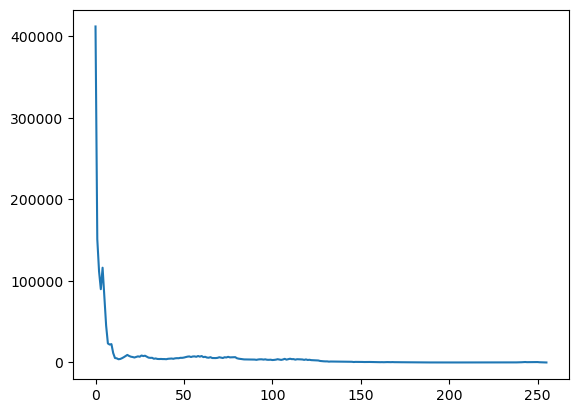

In [9]:
# Define where the sampling is done
split_sampling = 'training'

# Take % amount of samples of images from the training set to analyze
random.seed(642)
perc_samples = 0.25
n_samples = int(round(perc_samples*len(img_rel_paths_dict[split_sampling]), 0))
img_paths_analysis = random.sample(list(img_rel_paths_dict[split_sampling].keys()), n_samples)

# Read the images, preprocess and put both the source and the pre-processed image into a dictionary 
images = []
for img_key in img_paths_analysis:
    img_src = cv.imread(img_rel_paths_dict[split_sampling][img_key])
    images.append(img_src)

# The histogram for all images
hist = cv.calcHist(images, [0], None, [256], [0,256])
plt.plot(hist) 
plt.show()

### Analysis Per Image (Tests)

In [ ]:
# 1458 cut

In [221]:
# Ranges from 1377 to 15610 for the Training Data
img_key = 1702
img_paths_analysis = img_rel_paths_dict['training']
img_path = img_paths_analysis[img_key]
img_src = cv.imread(img_path)
img_src = cv.cvtColor(img_src, cv.COLOR_BGR2GRAY)

# Image to use for the tests
img = np.copy(img_src)

# CLAHE
img_e = enhance_contrast_img(img, clipLimit=2, tileGridSize=(10, 10))

## Thresholding
# tc_s, img_thr = cv.threshold(img, 130, 255, cv.THRESH_BINARY) # Simple Thresholding
tc_o, img_thr_o = cv.threshold(img_e, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU) # Binary Thresholding through the Otsu method
img_thr_am = cv.adaptiveThreshold(img_e, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 27, 7) # Adaptive Thresholding Mean C
img_thr_g = cv.adaptiveThreshold(img_e, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 27, 7)  # Adaptive Thresholding Gaussian C

## Gaussian Blur
blur_amount = (25, 25)
blur_sd = 5

# Gaussian Blur applied to each thresholded image to smooth it
img_blur_o = cv.GaussianBlur(img_thr_o, blur_amount, blur_sd)
img_blur_am = cv.GaussianBlur(img_thr_am, blur_amount, blur_sd)

## Contouring
# Find the contours
contours_o, hier_o = cv.findContours(img_blur_o, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_am, hier_am = cv.findContours(img_thr_am, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_g, hier_g = cv.findContours(img_thr_g, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Overlay the found contours on the original image
img_contour_o = np.copy(img_e)
img_contour_o = cv.cvtColor(img_contour_o, cv.COLOR_GRAY2BGR)
# cv.drawContours(img_contour_o, contours_o, -1, (0, 137, 0), -1)

img_contour_am = np.copy(img_e)
img_contour_am = cv.cvtColor(img_contour_am, cv.COLOR_GRAY2BGR)
cv.drawContours(img_contour_am, contours_am, -1, (0, 137, 0), -1)

img_contour_g = np.copy(img_e)
img_contour_g = cv.cvtColor(img_contour_g, cv.COLOR_GRAY2BGR)
cv.drawContours(img_contour_g, contours_g, -1, (0, 137, 0), -1)

# for contour in contours_o:
#     Approximate the contour with a polygon
#     approx = cv.approxPolyDP(contour, 0.01 * cv.arcLength(contour, True), True)
#     if len(approx) == 4:
#         If the contour has 4 corners, it is a rectangle
#         cv.drawContours(img_contour_o, [approx], 0, (0, 255, 0), 2)

# Find the largest contour
largest_contour = max(contours_o, key=cv.contourArea)

# Get the bounding box around the largest contour
x, y, w, h = cv.boundingRect(largest_contour)

# # Add padding to the bounding box
# padding = 50
# x -= padding
# y -= padding
# w += 2 * padding
# h += 2 * padding

# # Ensure that the bounding box stays within the image bounds
# x = max(0, x)
# y = max(0, y)
# w = min(img.shape[1] - x, w)
# h = min(img.shape[0] - y, h)

# Crop the image to only keep the hand
img_contour_o = img_contour_o[y:y+h, x:x+w]


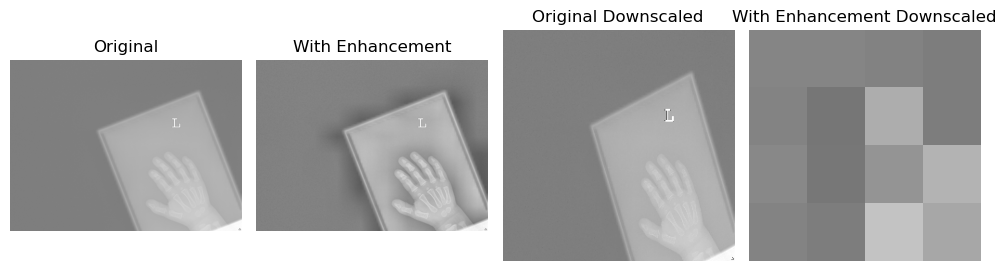

In [213]:
imgs_comp = [img, img_e, resize_img(img, 250, 250), resize_img(img_e, 4, 4)]
labels = ['Original', 'With Enhancement', 'Original Downscaled', 'With Enhancement Downscaled']
display_img_comp(imgs_comp, labels)

Image Analyzed: 1702


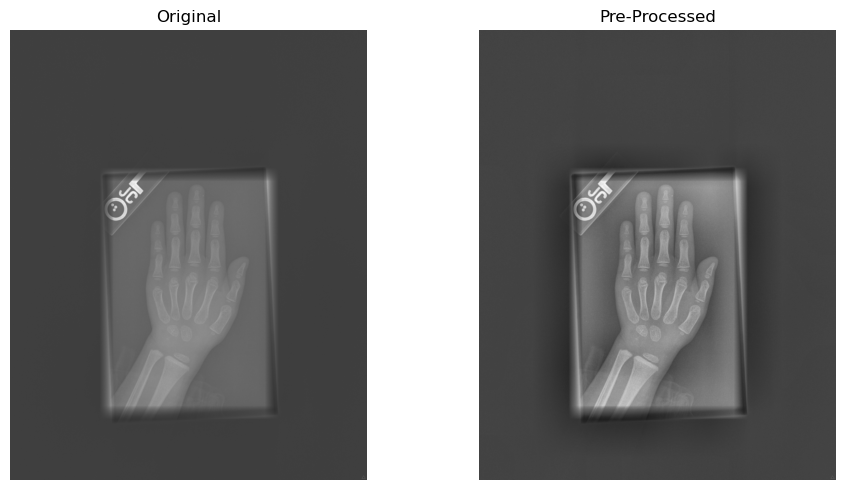

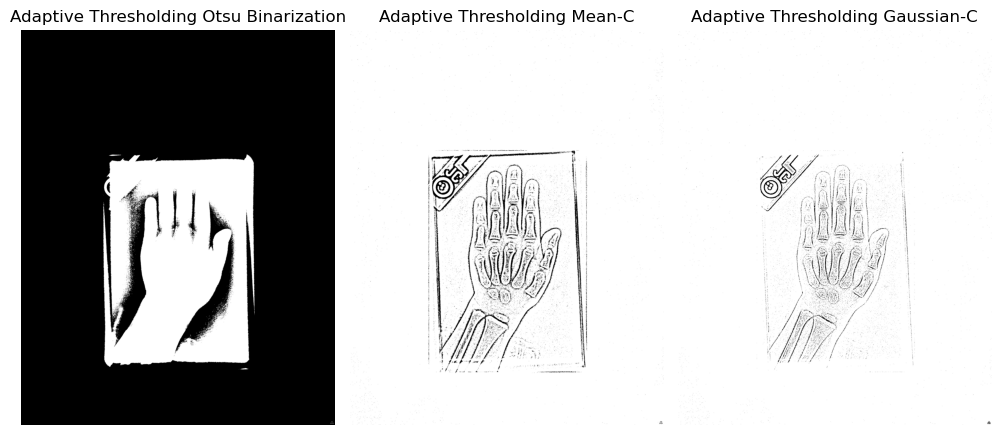

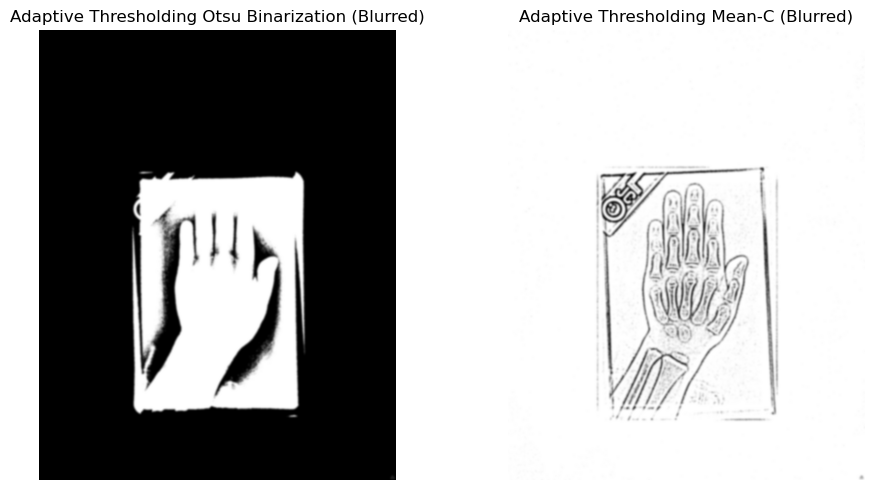

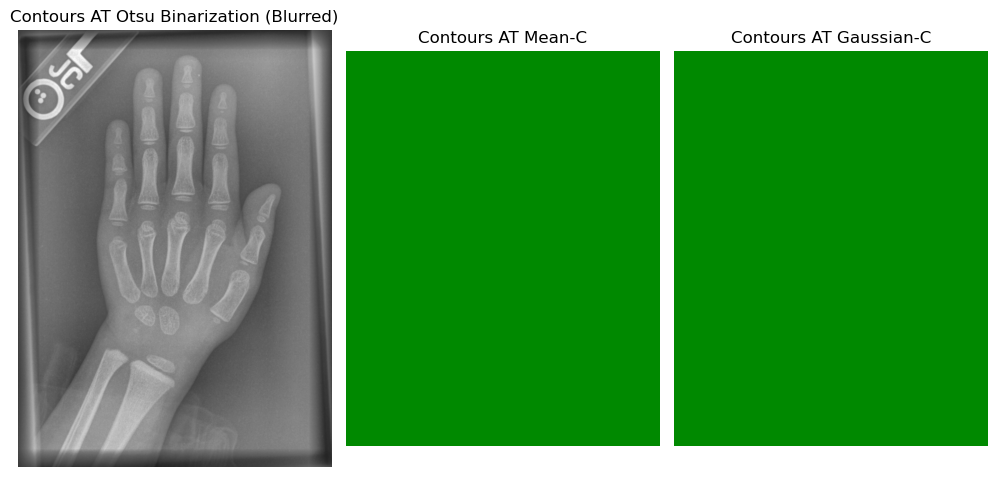

In [222]:
print('Image Analyzed: {0}'.format(img_key))

# Original vs. Processed
imgs_comp = [img, img_e]
labels = ['Original', 'Pre-Processed']
display_img_comp(imgs_comp, labels)

# Thresholding
imgs_comp = [img_thr_o, img_thr_am, img_thr_g]
labels = ['Adaptive Thresholding Otsu Binarization', 'Adaptive Thresholding Mean-C', 'Adaptive Thresholding Gaussian-C']
display_img_comp(imgs_comp, labels)

# Blurring
imgs_comp = [img_blur_o, img_blur_am]
labels = ['Adaptive Thresholding Otsu Binarization (Blurred)', 'Adaptive Thresholding Mean-C (Blurred)']
display_img_comp(imgs_comp, labels)

# Contours
imgs_comp = [img_contour_o, img_contour_am, img_contour_g]
labels = ['Contours AT Otsu Binarization (Blurred)', 'Contours AT Mean-C', 'Contours AT Gaussian-C']
display_img_comp(imgs_comp, labels)


In [137]:
## K-Means Segmentation
img_km = np.copy(resize_img(img_e, 4, 4))
# img_km = np.copy(img_blur_o)

# ## Gaussian Blur
# img_blur = cv.GaussianBlur(img_km, (1, 1), 1)

# Since the image is in grayscale (1 Channel) we only accomodate the rows into 1 column
img_reshaped = img_km.reshape((-1,1))
img_reshaped = np.float32(img_reshaped)

# Number of clusters
k = 2

# Clustering
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(img_reshaped, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# Assign labels to each pixel
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

display_img(res2)

ValueError: cannot reshape array of size 16 into shape (2044,1514)

In [ ]:
img_flood = np.copy(img_thr_g)
cv.floodill(img_flood, )

In [ ]:
# Hola Mundo!

# Como fue el proyecto al final?
# [] Bien
# [] Mal
# [] Que buena pregunta